
## Welcome

This is material for the **Difference-in-Differences** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)

<img src="https://mixtape.scunning.com/images/cover.jpg" alt="Causal Inference: The Mixtape" style="width: 200px;"/>

[View the Textbook](https://mixtape.scunning.com/)



### Packages needed

The first thing you need to do is install a few packages to make sure everything runs:

In [17]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [19]:
%%R 

install.packages("tidyverse")
install.packages("cli")
install.packages("haven")
install.packages("rmarkdown")
install.packages("learnr")
install.packages("haven")
install.packages("stargazer")

# This chapter only
install.packages("lfe")
install.packages("bacondecomp")

R[write to console]: trying URL 'https://cloud.r-project.org/bin/macosx/contrib/4.0/tidyverse_1.3.0.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 433049 bytes (422 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

### Load

In [ ]:
%%R 

library(learnr)
library(haven)
library(tidyverse)
library(stargazer)
library(estimatr)

# This chapter only
library(lfe)
library(bacondecomp)

# 10 minute code time limit
options(tutorial.exercise.timelimit = 600)

# read_data function
read_data <- function(df) {
  full_path <- paste0("https://raw.github.com/scunning1975/mixtape/master/", df)
  return(haven::read_dta(full_path))
}

## Cunningham and Cornwell (2013)

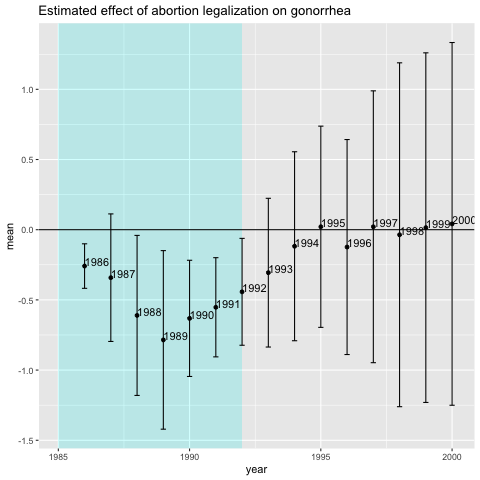

In [20]:
%%R 


#-- DD estimate of 15-19 year olds in repeal states vs Roe states
abortion <- read_data("abortion.dta") %>% 
  mutate(
    repeal = as_factor(repeal),
    year   = as_factor(year),
    fip    = as_factor(fip),
    fa     = as_factor(fa),
  )

reg <- abortion %>% 
  filter(bf15 == 1) %>% 
  lm_robust(lnr ~ repeal*year + fip + acc + ir + pi + alcohol+ crack + poverty+ income+ ur,
            data = ., weights = totpop, clusters = fip)

abortion_plot <- tibble(
  sd = reg$std.error[-1:-75],
  mean = reg$coefficients[-1:-75],
  year = c(1986:2000))

abortion_plot %>% 
  ggplot(aes(x = year, y = mean)) + 
  geom_rect(aes(xmin=1985, xmax=1992, ymin=-Inf, ymax=Inf), fill = "cyan", alpha = 0.01)+
  geom_point()+
  geom_text(aes(label = year), hjust=-0.002, vjust = -0.03)+
  geom_hline(yintercept = 0) +
  geom_errorbar(aes(ymin = mean - sd*1.96, ymax = mean + sd*1.96), width = 0.2,
                position = position_dodge(0.05)) +
  labs(title= "Estimated effect of abortion legalization on gonorrhea")


#### Questions
- Describe in your own words the testable predictions from the roll out of repeal versus Roe in the population?  In other words, describe the behavior of the DD coefficients under this regression.  
- Do we find evidence consistent with this in our DD analysis?  List all the evidence for and against the hypothesis in this analysis. 
- Does it appear that there was an effect in the period where Roe has not fully caught up?

In [ ]:
%%R 


abortion <- read_data("abortion.dta") %>% 
  mutate(
    repeal  = as_factor(repeal),
    year    = as_factor(year),
    fip     = as_factor(fip),
    fa      = as_factor(fa),
    younger = as_factor(younger),
    yr      = as_factor(case_when(repeal == 1 & younger == 1 ~ 1, TRUE ~ 0)),
    wm      = as_factor(case_when(wht == 1 & male == 1 ~ 1, TRUE ~ 0)),
    wf      = as_factor(case_when(wht == 1 & male == 0 ~ 1, TRUE ~ 0)),
    bm      = as_factor(case_when(wht == 0 & male == 1 ~ 1, TRUE ~ 0)),
    bf      = as_factor(case_when(wht == 0 & male == 0 ~ 1, TRUE ~ 0))
  ) %>% 
  filter(bf == 1 & (age == 15 | age == 25))

regddd <- lm_robust(lnr ~ repeal*year + younger*repeal + younger*year + yr*year + fip*t + acc + ir + pi + alcohol + crack + poverty + income + ur,
                    data = abortion, weights = totpop, clusters = fip)

abortion_plot <- tibble(
  sd = regddd$std.error[110:124],
  mean = regddd$coefficients[110:124],
  year = c(1986:2000))

abortion_plot %>% 
  ggplot(aes(x = year, y = mean)) + 
  geom_rect(aes(xmin=1986, xmax=1992, ymin=-Inf, ymax=Inf), fill = "cyan", alpha = 0.01)+
  geom_point()+
  geom_text(aes(label = year), hjust=-0.002, vjust = -0.03)+
  geom_hline(yintercept = 0) +
  geom_errorbar(aes(ymin = mean-sd*1.96, ymax = mean+sd*1.96), width = 0.2,
                position = position_dodge(0.05)) +
  labs(
    title= "Estimated effect of abortion legalization on gonorrhea", 
    subtitle= "Black female 15-19 year-olds vs. Black female 25-29 year-olds")


#### Questions
- Why did we implement a triple difference?  What problems does this solve and to what degree do you feel it is a necessary check?
- Describe the evidence for and against the abortion selection hypothesis when using triple difference?  How is it consistent with our DD and how is it not?

In [24]:
%%R 


abortion <- read_data("abortion.dta") %>% 
  mutate(
    repeal = as_factor(repeal),
    year   = as_factor(year),
    fip    = as_factor(fip),
    fa     = as_factor(fa),
  )

reg <- abortion %>% 
  filter(race == 2 & sex == 2 & age == 20) %>% 
  lm_robust(lnr ~ repeal*year + fip + acc + ir + pi + alcohol+ crack + poverty+ income+ ur,
            data = ., weights = totpop, clusters = fip)

reg


R[write to console]: 2 coefficients  not defined because the design matrix is rank deficient


                      Estimate   Std. Error     t value     Pr(>|t|)
(Intercept)       7.602837e+00 1.623449e+00  4.68313806 1.100363e-03
repeal1          -1.834799e+00 1.059618e+00 -1.73156557 1.310927e-01
year1986         -3.725933e-02 5.797045e-02 -0.64272966 5.342966e-01
year1987         -2.738323e-01 8.699342e-02 -3.14773539 1.122864e-02
year1988         -3.390973e-01 9.799287e-02 -3.46042801 6.834674e-03
year1989         -3.961768e-01 1.327990e-01 -2.98328111 1.478237e-02
year1990         -4.384593e-01 1.792363e-01 -2.44626429 3.560177e-02
year1991         -5.024699e-01 1.755754e-01 -2.86184624 1.647749e-02
year1992         -7.625938e-01 2.233224e-01 -3.41476694 6.350456e-03
year1993         -9.653762e-01 2.453721e-01 -3.93433576 2.726431e-03
year1994         -1.051011e+00 2.928454e-01 -3.58896114 5.369487e-03
year1995         -1.349939e+00 3.561916e-01 -3.78992277 3.702020e-03
year1996

In [25]:
%%R 


abortion <- read_data("abortion.dta") %>% 
  mutate(
    repeal   = as_factor(repeal),
    year     = as_factor(year),
    fip      = as_factor(fip),
    fa       = as_factor(fa),
    younger2 = case_when(age == 20 ~ 1, TRUE ~ 0),
    yr2      = as_factor(case_when(repeal == 1 & younger2 == 1 ~ 1, TRUE ~ 0)),
    wm       = as_factor(case_when(wht == 1 & male == 1 ~ 1, TRUE ~ 0)),
    wf       = as_factor(case_when(wht == 1 & male == 0 ~ 1, TRUE ~ 0)),
    bm       = as_factor(case_when(wht == 0 & male == 1 ~ 1, TRUE ~ 0)),
    bf       = as_factor(case_when(wht == 0 & male == 0 ~ 1, TRUE ~ 0))
  )

regddd <- abortion %>% 
  filter(bf == 1 & (age == 20 | age ==25)) %>% 
  lm_robust(lnr ~ repeal*year + acc + ir + pi + alcohol + crack + poverty + income + ur,
            data = ., weights = totpop, clusters = fip)

regddd

R[write to console]: 1 coefficient  not defined because the design matrix is rank deficient


                      Estimate   Std. Error     t value     Pr(>|t|)
(Intercept)       8.433661e+00 8.327002e-01 10.12808800 3.700482e-07
repeal1          -5.875999e-01 6.958167e-01 -0.84447520 5.220124e-01
year1986          5.160932e-03 7.997606e-02  0.06453095 9.497046e-01
year1987         -8.704527e-02 1.269159e-01 -0.68584982 5.072807e-01
year1988          7.203717e-02 1.425038e-01  0.50551057 6.229153e-01
year1989          1.851568e-01 1.819418e-01  1.01767079 3.294878e-01
year1990          1.857473e-01 1.917068e-01  0.96891369 3.527218e-01
year1991          1.639691e-01 2.194974e-01  0.74702058 4.686144e-01
year1992          1.738984e-02 2.472691e-01  0.07032760 9.449839e-01
year1993         -2.548390e-01 3.608602e-01 -0.70619863 4.932977e-01
year1994         -6.668714e-02 3.449518e-01 -0.19332303 8.495652e-01
year1995         -3.105068e-01 4.395565e-01 -0.70640943 4.924685e-01
year1996 

#### Questions
- Why did we suggest that conducting this additional analysis not conducted in the original study?
- How convinced are you now of the abortion selection hypothesis?  Why/why not?
- Could you have concluded this had you not exploited all of the testable predictions of the original table showing roll out across cohort and time?  
- How important was our ``model`` to forming testable predictions and falsifications? 

## Cheng and Hoekstra (2013)

In [26]:
%%R 


castle <- read_data("castle.dta")

#--- global variables
crime1 <- c("jhcitizen_c", "jhpolice_c", 
            "murder", "homicide", 
            "robbery", "assault", "burglary",
            "larceny", "motor", "robbery_gun_r")

demo <- c("emo", "blackm_15_24", "whitem_15_24", 
          "blackm_25_44", "whitem_25_44")

# variables dropped to prevent colinearity
dropped_vars <- c("r20004", "r20014",
                  "r20024", "r20034",
                  "r20044", "r20054",
                  "r20064", "r20074",
                  "r20084", "r20094",
                  "r20101", "r20102", "r20103",
                  "r20104", "trend_9", "trend_46",
                  "trend_49", "trend_50", "trend_51"
)

lintrend <- castle %>%
    select(starts_with("trend")) %>% 
  colnames %>% 
  # remove due to colinearity
  subset(.,! . %in% dropped_vars) 

region <- castle %>%
  select(starts_with("r20")) %>% 
  colnames %>% 
  # remove due to colinearity
  subset(.,! . %in% dropped_vars) 


exocrime <- c("l_lacerny", "l_motor")
spending <- c("l_exp_subsidy", "l_exp_pubwelfare")


xvar <- c(
  "blackm_15_24", "whitem_15_24", "blackm_25_44", "whitem_25_44",
  "l_exp_subsidy", "l_exp_pubwelfare",
  "l_police", "unemployrt", "poverty", 
  "l_income", "l_prisoner", "l_lagprisoner"
)

law <- c("cdl")

dd_formula <- as.formula(
  paste("l_homicide ~ ",
        paste(
          paste(xvar, collapse = " + "),
          paste(region, collapse = " + "),
          paste(lintrend, collapse = " + "),
          paste("post", collapse = " + "), sep = " + "),
        "| year + sid | 0 | sid"
  )
)

#Fixed effect regression using post as treatment variable 
dd_reg <- lfe::felm(dd_formula, weights = castle$popwt, data = castle)
summary(dd_reg)




Call:
   lfe::felm(formula = dd_formula, data = castle, weights = castle$popwt) 

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-583.16 -125.93   14.52  131.33  802.67 

Coefficients:
                  Estimate Cluster s.e. t value Pr(>|t|)    
blackm_15_24      0.061350     0.106121   0.578 0.565833    
whitem_15_24      0.036005     0.026882   1.339 0.186629    
blackm_25_44      0.222539     0.121761   1.828 0.073692 .  
whitem_25_44     -0.027786     0.011792  -2.356 0.022494 *  
l_exp_subsidy    -0.041280     0.038623  -1.069 0.290404    
l_exp_pubwelfare  0.036840     0.060923   0.605 0.548174    
l_police          0.108324     0.055149   1.964 0.055190 .  
unemployrt        0.013194     0.011947   1.104 0.274821    
poverty          -0.019154     0.012602  -1.520 0.134949    
l_income         -0.312413     0.159640  -1.957 0.056060 .  
l_prisoner       -0.129783     0.191577  -0.677 0.501310    
l_lagprisoner    -0.423202     0.244438  -1.731 0.089687 .  
r20001 

#### QUESTIONS

- What effect does this analysis say reforming castle doctrine laws has on homicides?
- What are the key parts of these legislative reforms that you think may be causing this result?
- Explain what SUTVA requires in order for these estimates to be causal?
- Assume there are spillovers to neighboring states created by castle doctrine reforms.  Does that imply that Cheng and Hoekstra's result is too large or too small?  Why/why not?

In [27]:
%%R 

castle <- castle %>%
  mutate(
    time_til = year - treatment_date,
    lead1 = case_when(time_til == -1 ~ 1, TRUE ~ 0),
    lead2 = case_when(time_til == -2 ~ 1, TRUE ~ 0),
    lead3 = case_when(time_til == -3 ~ 1, TRUE ~ 0),
    lead4 = case_when(time_til == -4 ~ 1, TRUE ~ 0),
    lead5 = case_when(time_til == -5 ~ 1, TRUE ~ 0),
    lead6 = case_when(time_til == -6 ~ 1, TRUE ~ 0),
    lead7 = case_when(time_til == -7 ~ 1, TRUE ~ 0),
    lead8 = case_when(time_til == -8 ~ 1, TRUE ~ 0),
    lead9 = case_when(time_til == -9 ~ 1, TRUE ~ 0),
    lag0 = case_when(time_til == 0 ~ 1, TRUE ~ 0),
    lag1 = case_when(time_til == 1 ~ 1, TRUE ~ 0),
    lag2 = case_when(time_til == 2 ~ 1, TRUE ~ 0),
    lag3 = case_when(time_til == 3 ~ 1, TRUE ~ 0),
    lag4 = case_when(time_til == 4 ~ 1, TRUE ~ 0),
    lag5 = case_when(time_til == 5 ~ 1, TRUE ~ 0)
  )

event_study_formula <- as.formula(
  paste("l_homicide ~ + ",
        paste(
          paste(region, collapse = " + "),
          paste(paste("lead", 1:9, sep = ""), collapse = " + "),
          paste(paste("lag", 1:5, sep = ""), collapse = " + "), sep = " + "),
        "| year + state | 0 | sid"
  ),
)

event_study_reg <- lfe::felm(event_study_formula, weights = castle$popwt, data = castle)
summary(event_study_reg)



Call:
   lfe::felm(formula = event_study_formula, data = castle, weights = castle$popwt) 

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-824.4 -146.8   -4.0  150.6  861.3 

Coefficients:
        Estimate Cluster s.e. t value Pr(>|t|)    
r20001 -0.261336     0.097507  -2.680 0.009994 ** 
r20002  0.050859     0.060507   0.841 0.404684    
r20003  0.083008     0.053407   1.554 0.126561    
r20011 -0.280162     0.073152  -3.830 0.000365 ***
r20012 -0.050701     0.058409  -0.868 0.389603    
r20013 -0.054429     0.049400  -1.102 0.275931    
r20021 -0.325537     0.066526  -4.893 1.11e-05 ***
r20022 -0.120830     0.067428  -1.792 0.079312 .  
r20023 -0.064912     0.052008  -1.248 0.217923    
r20031 -0.287791     0.076030  -3.785 0.000419 ***
r20032 -0.120198     0.063533  -1.892 0.064421 .  
r20033 -0.044143     0.053278  -0.829 0.411381    
r20041 -0.302958     0.047020  -6.443 4.84e-08 ***
r20042 -0.186868     0.041304  -4.524 3.87e-05 ***
r20043 -0.092467     0.044764  -2.06

#### QUESTIONS
- Put into your own words why we estimated the pre-treatment leads?
- Put into your own words what we expected to find?
- How convinced are you by this analysis that parallel trends was likely to hold in Cheng and Hoekstra's data?

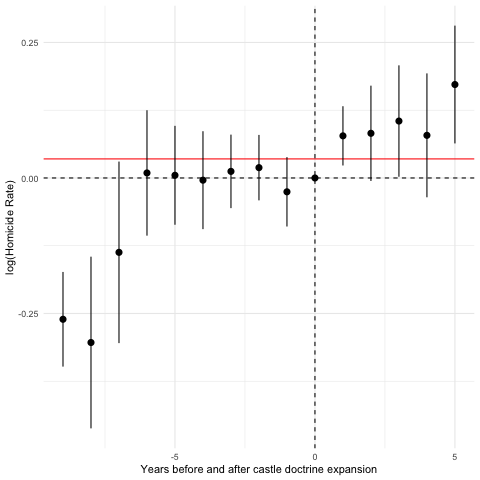

In [28]:
%%R 


castle <- castle %>%
  mutate(
    time_til = year - treatment_date,
    lead1 = case_when(time_til == -1 ~ 1, TRUE ~ 0),
    lead2 = case_when(time_til == -2 ~ 1, TRUE ~ 0),
    lead3 = case_when(time_til == -3 ~ 1, TRUE ~ 0),
    lead4 = case_when(time_til == -4 ~ 1, TRUE ~ 0),
    lead5 = case_when(time_til == -5 ~ 1, TRUE ~ 0),
    lead6 = case_when(time_til == -6 ~ 1, TRUE ~ 0),
    lead7 = case_when(time_til == -7 ~ 1, TRUE ~ 0),
    lead8 = case_when(time_til == -8 ~ 1, TRUE ~ 0),
    lead9 = case_when(time_til == -9 ~ 1, TRUE ~ 0),
    
    lag0 = case_when(time_til == 0 ~ 1, TRUE ~ 0),
    lag1 = case_when(time_til == 1 ~ 1, TRUE ~ 0),
    lag2 = case_when(time_til == 2 ~ 1, TRUE ~ 0),
    lag3 = case_when(time_til == 3 ~ 1, TRUE ~ 0),
    lag4 = case_when(time_til == 4 ~ 1, TRUE ~ 0),
    lag5 = case_when(time_til == 5 ~ 1, TRUE ~ 0)
  )

event_study_formula <- as.formula(
  paste("l_homicide ~ + ",
        paste(
          paste(region, collapse = " + "),
          paste(paste("lead", 1:9, sep = ""), collapse = " + "),
          paste(paste("lag", 1:5, sep = ""), collapse = " + "), sep = " + "),
        "| year + state | 0 | sid"
  ),
)

event_study_reg <- lfe::felm(event_study_formula, weights = castle$popwt, data = castle)

# order of the coefficients for the plot
plot_order <- c("lead9", "lead8", "lead7", 
                "lead6", "lead5", "lead4", "lead3", 
                "lead2", "lead1", "lag1", 
                "lag2", "lag3", "lag4", "lag5")

# grab the clustered standard errors
# and average coefficient estimates
# from the regression, label them accordingly
# add a zero'th lag for plotting purposes
leadslags_plot <- tibble(
  sd = c(event_study_reg$cse[plot_order], 0),
  mean = c(coef(event_study_reg)[plot_order], 0),
  label = c(-9,-8,-7,-6, -5, -4, -3, -2, -1, 1,2,3,4,5, 0)
)

# This version has a point-range at each
# estimated lead or lag
# comes down to stylistic preference at the
# end of the day!
leadslags_plot %>%
  ggplot(aes(x = label, y = mean,
             ymin = mean-1.96*sd, 
             ymax = mean+1.96*sd)) +
  geom_hline(yintercept = 0.035169444, color = "red") +
  geom_pointrange() +
  theme_minimal() +
  xlab("Years before and after castle doctrine expansion") +
  ylab("log(Homicide Rate)") +
  geom_hline(yintercept = 0,
             linetype = "dashed") +
  geom_vline(xintercept = 0,
             linetype = "dashed")
  
